# Research Question: Can we predict the outcome of all the games post like april or smt (train/test 70/30)?

Things we know:
1. Features are constructed as the difference in averaged game statistics before current game date
2. Label is the current game result
3. Home advantage was taken into consideration by introducing binary variable
4. Prediction testing accuracy is roughly 67% by a random forest classifier
5. Combat this by using weighted averaged game statistics
6. Assign higher weights to the game statistics that occur closer to November 13
7. MUST FIGURE OUT HOW TO CONSTRUCT WEIGHTING FUNCTION
8.  Key question: consider how to collect data about the two teams before the event at time Point A and integrate it into meaningful features for prediction
9. Ex) Use average score point difference as a feature for prediction
10. Try different models to select best predictive model

Homecourt advantage win ratio of all the home games for specific teams
Add it as a weight to probability of win loss

Stability - check for constant variance per team

Offense defense free throw stats could also be predictors.
  



### Resources:

https://www.linkedin.com/pulse/predicting-sports-outcomes-simple-probability-model-michael-bagalman-g2rne/

https://digitalcommons.bryant.edu/cgi/viewcontent.cgi?article=1000&context=honors_data_science

### Things the TA said
- need to use CV result to test 3 methods like LDA, decision tree, logistic regression and find the one with the smallest CV error




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

nba_df = pd.read_csv('https://raw.githubusercontent.com/Elisep03/nba-dataset/refs/heads/main/Dataset.csv')

nba_df.head()

,Team,Match Up,Game Date,W/L,MIN,PTS,FGM,FGA,FG%,3PM,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,PF,+/-
0,GSW,GSW vs. PHX,10/24/2023,L,240,104,36,101,35.6,10,...,78.6,18,31,49,19,11,6,11,23,-4
1,PHX,PHX @ GSW,10/24/2023,W,240,108,42,95,44.2,11,...,76.5,17,43,60,23,5,7,19,22,4
2,LAL,LAL @ DEN,10/24/2023,L,240,107,41,90,45.6,10,...,75,13,31,44,23,5,4,12,18,-12
3,DEN,DEN vs. LAL,10/24/2023,W,240,119,48,91,52.7,14,...,75,9,33,42,29,9,6,12,15,12
4,MEM,MEM vs. NOP,10/25/2023,L,240,104,38,91,41.8,12,...,80,8,29,37,23,8,7,13,19,-7


In [ ]:
#home advantage?
Home = []
for i in range(nba_df.shape[0]):
  if nba_df.iloc[:, 1][i][4:6] == 'vs':
    Home.append(1)
  if nba_df.iloc[:,1][i][4:6]=='@ ':
        Home.append(0)
nba_df['home'] = np.array(Home)
nba_df.loc[nba_df['W/L'] == 'W', 'W/L'] = 1
nba_df.loc[nba_df['W/L'] == 'L', 'W/L'] = 0
nba_df.loc[nba_df['FT%']=='-','FT%'] = 1

In [ ]:
Features = ['W/L','PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
for i in Features:
    nba_df[i] = nba_df[i].astype(float)

In [ ]:
#weighted average
def Weighting_fun(L,alpha = 0.5):
    out = [np.exp(-alpha * i/5) for i in np.arange(L,0,-1)]
    out /= np.sum(out)
    #print(out)
    return out

In [ ]:
# stability example (ignore but don't delete)
    X_all = []
    Y_all = []
Team_1 = nba_df.iloc[0, 0] #GSW
Team_2 = nba_df.iloc[0, 1][-3::] #PHX
Data_Previous_1 = (nba_df.iloc[0:(0 - 1), :][nba_df.iloc[0:(0 - 1), 0] == Team_1])
Data_Previous_2 = (nba_df.iloc[0:(0 - 1), :][nba_df.iloc[0:(0 - 1), 0] == Team_2])
Data_Previous_1 = Data_Previous_1[Data_Previous_1['Game Date'] != nba_df.iloc[0, 2]]
Data_Previous_2 = Data_Previous_2[Data_Previous_2['Game Date'] != nba_df.iloc[0, 2]]
Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == nba_df.iloc[0, -1]][Features])
Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - nba_df.iloc[0, -1])][Features])
W1 = Weighting_fun(Data_Previous_1_home.shape[0]).reshape(-1, 1)
W2 = Weighting_fun(Data_Previous_2_home.shape[0]).reshape(-1, 1)
Data_1 = np.array(Data_Previous_1_home * W1).sum(axis=0)
Data_2 = np.array(Data_Previous_2_home * W2).sum(axis=0)
Diff = (Data_1 - Data_2).tolist() + [nba_df.iloc[0, -1]]
X_all.append(Diff)
Y_all.append(nba_df.iloc[0]['W/L'])

    X = np.array(X_all)
    y = np.array(Y_all)

var1 = Data_Previous_1[Data_Previous_1['home'] == nba_df.iloc[0, -1]]["PTS"].var()
var2 = Data_Previous_2[Data_Previous_2['home'] == nba_df.iloc[0, -1]]["PTS"].var()
#print(var1 - var2)


37.78885240775482


In [ ]:
#this is where we actually apply stability and weighted function (professor given historical data part)
#extract all features after 500 games
from sklearn import svm

def Rati_Error(alpha):
    X_all = []
    Y_all = []
    for i in np.arange(500, nba_df.shape[0]):
        Team_1 = nba_df.iloc[i, 0]
        Team_2 = nba_df.iloc[i, 1][-3::]
        Data_Previous_1 = (nba_df.iloc[0:(i - 1), :][nba_df.iloc[0:(i - 1), 0] == Team_1])
        Data_Previous_2 = (nba_df.iloc[0:(i - 1), :][nba_df.iloc[0:(i - 1), 0] == Team_2])
        Data_Previous_1 = Data_Previous_1[Data_Previous_1['Game Date'] != nba_df.iloc[i, 2]]
        Data_Previous_2 = Data_Previous_2[Data_Previous_2['Game Date'] != nba_df.iloc[i, 2]]
        Data_Previous_1_home = np.array(Data_Previous_1 [Data_Previous_1['home'] == nba_df.iloc[i, -1]][Features])
        Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - nba_df.iloc[i, -1])][Features])
        W1 = Weighting_fun(Data_Previous_1_home.shape[0], alpha).reshape(-1, 1)
        W2 = Weighting_fun(Data_Previous_2_home.shape[0], alpha).reshape(-1, 1)
        stability1 = Data_Previous_1[Data_Previous_1['home'] == nba_df.iloc[i, -1]]["PTS"].var()
        stability2 = Data_Previous_2[Data_Previous_2['home'] == nba_df.iloc[i, -1]]["PTS"].var()
        Data_1 = np.array(Data_Previous_1_home * W1).sum(axis=0)
        Data_2 = np.array(Data_Previous_2_home * W2).sum(axis=0)
        Diff = (Data_1 - Data_2).tolist() + [stability1 - stability2, nba_df.iloc[i, -1]]
        X_all.append(Diff)
        Y_all.append(nba_df.iloc[i]['W/L'])

    X = np.array(X_all)
    y = np.array(Y_all)

    N = len(y)
    R = 0.75
    Int = int(N * R)
    X_train, X_test, y_train, y_test = X[0:Int, :], X[Int::, :], y[0:Int], y[Int::]
    model = svm.SVC()
    model.fit(X_train, y_train)
    # Predict using the SVM model
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    train_accuracy = model.score(X_train, y_train)
    print("Testing Accuracy of SVM:", accuracy)

for i in np.linspace(0.05,0.5,10):
    Rati_Error(i)

Testing Accuracy of SVM: 0.6959183673469388
Testing Accuracy of SVM: 0.7061224489795919
Testing Accuracy of SVM: 0.7061224489795919
Testing Accuracy of SVM: 0.7020408163265306
Testing Accuracy of SVM: 0.7040816326530612
Testing Accuracy of SVM: 0.7020408163265306
Testing Accuracy of SVM: 0.7040816326530612
Testing Accuracy of SVM: 0.7061224489795919
Testing Accuracy of SVM: 0.6979591836734694
Testing Accuracy of SVM: 0.7


In [ ]:
def Rati_Error(alpha):
    X_all = []
    Y_all = []
    for i in np.arange(500, nba_df.shape[0]):
        Team_1 = nba_df.iloc[i, 0]
        Team_2 = nba_df.iloc[i, 1][-3::]
        Data_Previous_1 = (nba_df.iloc[0:(i - 1), :][nba_df.iloc[0:(i - 1), 0] == Team_1])
        Data_Previous_2 = (nba_df.iloc[0:(i - 1), :][nba_df.iloc[0:(i - 1), 0] == Team_2])
        Data_Previous_1 = Data_Previous_1[Data_Previous_1['Game Date'] != nba_df.iloc[i, 2]]
        Data_Previous_2 = Data_Previous_2[Data_Previous_2['Game Date'] != nba_df.iloc[i, 2]]
        Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == nba_df.iloc[i, -1]][Features])
        Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - nba_df.iloc[i, -1])][Features])
        W1 = Weighting_fun(Data_Previous_1_home.shape[0], alpha).reshape(-1, 1)
        W2 = Weighting_fun(Data_Previous_2_home.shape[0], alpha).reshape(-1, 1)
        stability1 = Data_Previous_1[Data_Previous_1['home'] == nba_df.iloc[i, -1]]["PTS"].var()
        stability2 = Data_Previous_2[Data_Previous_2['home'] == nba_df.iloc[i, -1]]["PTS"].var()
        Data_1 = np.array(Data_Previous_1_home * W1).sum(axis=0)
        Data_2 = np.array(Data_Previous_2_home * W2).sum(axis=0)
        Diff = (Data_1 - Data_2).tolist() + [stability1 - stability2, nba_df.iloc[i, -1]]
        X_all.append(Diff)
        Y_all.append(nba_df.iloc[i]['W/L'])

    X = np.array(X_all)
    y = np.array(Y_all)

    N = len(y)
    R = 0.75
    Int = int(N * R)
    X_train, X_test, y_train, y_test = X[0:Int, :], X[Int::, :], y[0:Int], y[Int::]

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    # Predict using the LDA model
    y_pred_lda = lda.predict(X_test)
    print("Testing Accuracy of LDA:", accuracy_score(y_test, y_pred_lda))

for i in np.linspace(0.05,0.5,10):
    Rati_Error(i)

Testing Accuracy of LDA: 0.7020408163265306
Testing Accuracy of LDA: 0.7081632653061225
Testing Accuracy of LDA: 0.7040816326530612
Testing Accuracy of LDA: 0.6979591836734694
Testing Accuracy of LDA: 0.6979591836734694
Testing Accuracy of LDA: 0.7
Testing Accuracy of LDA: 0.7020408163265306
Testing Accuracy of LDA: 0.689795918367347
Testing Accuracy of LDA: 0.689795918367347
Testing Accuracy of LDA: 0.7020408163265306


In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_all = []
Y_all = []
for i in np.arange(500, nba_df.shape[0]):
    Team_1 = nba_df.iloc[i, 0]
    Team_2 = nba_df.iloc[i, 1][-3:]
    Data_Previous_1 = (nba_df.iloc[0:(i - 1), :][nba_df.iloc[0:(i - 1), 0] == Team_1])
    Data_Previous_2 = (nba_df.iloc[0:(i - 1), :][nba_df.iloc[0:(i - 1), 0] == Team_2])
    Data_Previous_1 = Data_Previous_1[Data_Previous_1['Game Date'] != nba_df.iloc[i, 2]]
    Data_Previous_2 = Data_Previous_2[Data_Previous_2['Game Date'] != nba_df.iloc[i, 2]]
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == nba_df.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - nba_df.iloc[i, -1])][Features])
    W1 = Weighting_fun(Data_Previous_1_home.shape[0], 0.5).reshape(-1, 1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0], 0.5).reshape(-1, 1)
    stability1 = Data_Previous_1[Data_Previous_1['home'] == nba_df.iloc[i, -1]]["PTS"].var()
    stability2 = Data_Previous_2[Data_Previous_2['home'] == nba_df.iloc[i, -1]]["PTS"].var()
    Data_1 = np.array(Data_Previous_1_home * W1).sum(axis=0)
    Data_2 = np.array(Data_Previous_2_home * W2).sum(axis=0)
    Diff = (Data_1 - Data_2).tolist() + [stability1 - stability2, nba_df.iloc[i, -1]]
    X_all.append(Diff)
    Y_all.append(nba_df.iloc[i]['W/L'])

X = np.array(X_all)
y = np.array(Y_all)
scaler = StandardScaler()
X = scaler.fit_transform(X)

N = len(y)
R = 0.75
Int = int(N * R)
X_train, X_test, y_train, y_test = X[0:Int, :], X[Int::, :], y[0:Int], y[Int::]

# Define hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        "penalty": ["l2"],
        "C": [0.1, 1, 10],
        "solver": ["lbfgs"]
    },
    "LDA": {},  # No hyperparameters to tune for LDA
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf"]
    }
}

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Perform hyperparameter tuning using GridSearchCV
best_models = {}
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    param_grid = param_grids.get(model_name, {})
    if param_grid:  # Only perform GridSearchCV if hyperparameters are defined
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[model_name] = model

# Evaluate all tuned models on the test set
results = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[model_name] = acc
    print(f"{model_name}: Test Accuracy = {acc:.2f}")

# Find the best model
best_model = max(results, key=results.get)
print("\nBest Model:", best_model, "with accuracy:", results[best_model])

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuning hyperparameters for LDA...
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Tuning hyperparameters for SVM...
Best parameters for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Logistic Regression: Test Accuracy = 0.71
LDA: Test Accuracy = 0.70
Random Forest: Test Accuracy = 0.67
Gradient Boosting: Test Accuracy = 0.64
SVM: Test Accuracy = 0.68

Best Model: Logistic Regression with accuracy: 0.710204081632653


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Path to dataset
df = pd.read_csv('https://raw.githubusercontent.com/Elisep03/nba-dataset/refs/heads/main/Dataset.csv')

# Processing the dataset (similar to before)
Home = []
for i in range(df.shape[0]):
    if df.iloc[:, 1][i][4:6] == 'vs':
        Home.append(1)
    elif df.iloc[:, 1][i][4:6] == '@ ':
        Home.append(0)
df['home'] = np.array(Home)
df.loc[df['W/L'] == 'W', 'W/L'] = 1
df.loc[df['W/L'] == 'L', 'W/L'] = 0
df.loc[df['FT%'] == '-', 'FT%'] = 1

# Convert features to numeric
Features = ['W/L', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA',
            'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-']
for feature in Features:
    df[feature] = df[feature].astype(float)

# Feature engineering (same as before)
def Weighting_fun(L, alpha=0.5):
    Res = [alpha ** i for i in np.arange(L, 0, -1)]
    Res /= np.sum(Res)
    return Res

X_all = []
Y_all = []
for i in np.arange(300, df.shape[0]):
    Team_1 = df.iloc[i, 0]
    Team_2 = df.iloc[i, 1][-3:]
    Data_Previous_1 = df.iloc[0:i, :][df.iloc[0:i, 0] == Team_1]
    Data_Previous_2 = df.iloc[0:i, :][df.iloc[0:i, 0] == Team_2]
    Data_Previous_1_home = np.array(Data_Previous_1[Data_Previous_1['home'] == df.iloc[i, -1]][Features])
    Data_Previous_2_home = np.array(Data_Previous_2[Data_Previous_2['home'] == (1 - df.iloc[i, -1])][Features])
    W1 = Weighting_fun(Data_Previous_1_home.shape[0], 0.4).reshape(-1, 1)
    W2 = Weighting_fun(Data_Previous_2_home.shape[0], 0.4).reshape(-1, 1)
    Data_1 = np.array(Data_Previous_1_home[:, 3:] * W1).mean(axis=0)
    Data_2 = np.array(Data_Previous_2_home[:, 3:] * W2).mean(axis=0)
    Stability_1 = np.std(Data_Previous_1_home[:, 3:], axis=0).mean()
    Stability_2 = np.std(Data_Previous_2_home[:, 3:], axis=0).mean()
    Diff = (Data_1 - Data_2).tolist() + [Stability_1 - Stability_2, df.iloc[i, -1]]
    X_all.append(Diff)
    Y_all.append(df.iloc[i]['W/L'])

# Prepare data
X = np.array(X_all)
y = np.array(Y_all)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define hyperparameter grids for each model
param_grids = {
    "Logistic Regression": {
        "penalty": ["l2"],
        "C": [0.1, 1, 10],
        "solver": ["lbfgs"]
    },
    "LDA": {},  # No hyperparameters to tune for LDA
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf"]
    }
}

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Perform hyperparameter tuning using GridSearchCV
best_models = {}
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    param_grid = param_grids.get(model_name, {})
    if param_grid:  # Only perform GridSearchCV if hyperparameters are defined
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[model_name] = model

# Evaluate all tuned models on the test set
results = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[model_name] = acc
    print(f"{model_name}: Test Accuracy = {acc:.2f}")

# Find the best model
best_model = max(results, key=results.get)

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuning hyperparameters for LDA...
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Tuning hyperparameters for SVM...
Best parameters for SVM: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Logistic Regression: Test Accuracy = 0.71
LDA: Test Accuracy = 0.70
Random Forest: Test Accuracy = 0.69
Gradient Boosting: Test Accuracy = 0.69
SVM: Test Accuracy = 0.69


Performing 5-fold CV for Logistic Regression...
Logistic Regression: CV Scores = [0.69444444 0.7037037  0.67824074 0.67824074 0.67361111]
Logistic Regression: Mean CV Accuracy = 0.69
Performing 5-fold CV for LDA...
LDA: CV Scores = [0.68981481 0.69907407 0.6875     0.67824074 0.6712963 ]
LDA: Mean CV Accuracy = 0.69
Performing 5-fold CV for Random Forest...
Random Forest: CV Scores = [0.70833333 0.68518519 0.67824074 0.66666667 0.65740741]
Random Forest: Mean CV Accuracy = 0.68
Performing 5-fold CV for Gradient Boosting...
Gradient Boosting: CV Scores = [0.69212963 0.68055556 0.69675926 0.7037037  0.67361111]
Gradient Boosting: Mean CV Accuracy = 0.69
Performing 5-fold CV for SVM...
SVM: CV Scores = [0.69212963 0.67824074 0.67361111 0.67361111 0.65740741]
SVM: Mean CV Accuracy = 0.68


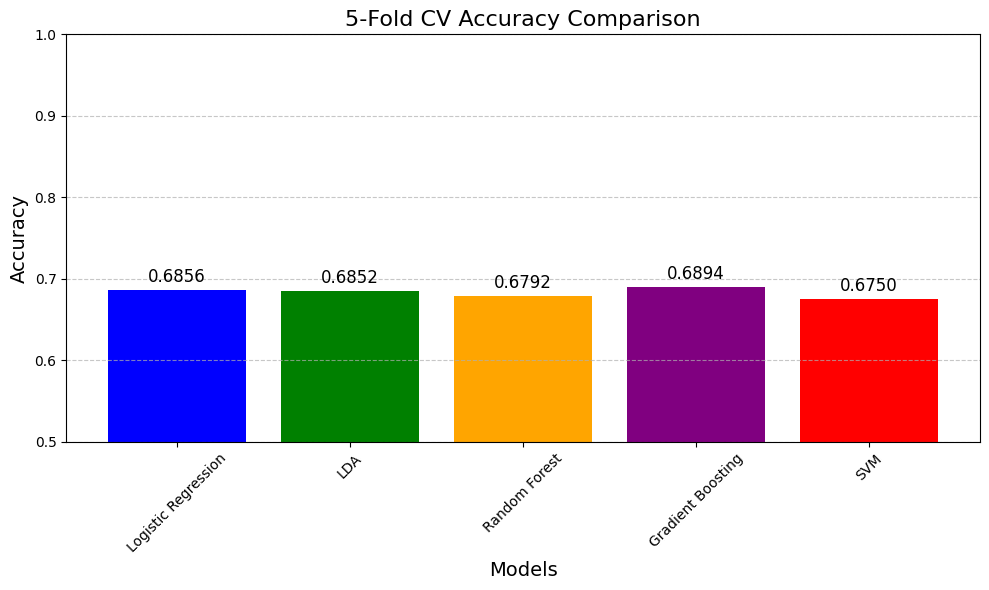

In [ ]:
import matplotlib.pyplot as plt

# Perform 5-fold cross-validation for each model
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in best_models.items():
    print(f"Performing 5-fold CV for {model_name}...")
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring="accuracy")
    cv_results[model_name] = cv_scores
    print(f"{model_name}: CV Scores = {cv_scores}")
    print(f"{model_name}: Mean CV Accuracy = {cv_scores.mean():.2f}")

# Plotting the 5-fold CV accuracy
fig, ax = plt.subplots(figsize=(10, 6))
average_accuracies = [scores.mean() for scores in cv_results.values()]
model_names = list(cv_results.keys())

ax.bar(model_names, average_accuracies, color=['blue', 'green', 'orange', 'purple', 'red'])
ax.set_title("5-Fold CV Accuracy Comparison", fontsize=16)
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xlabel("Models", fontsize=14)
ax.set_ylim(0.5, 1.0)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate the bars with accuracy values
for i, acc in enumerate(average_accuracies):
    ax.text(i, acc + 0.01, f"{acc:.4f}", ha='center', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Missing values in the dataset:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

Feature distributions:


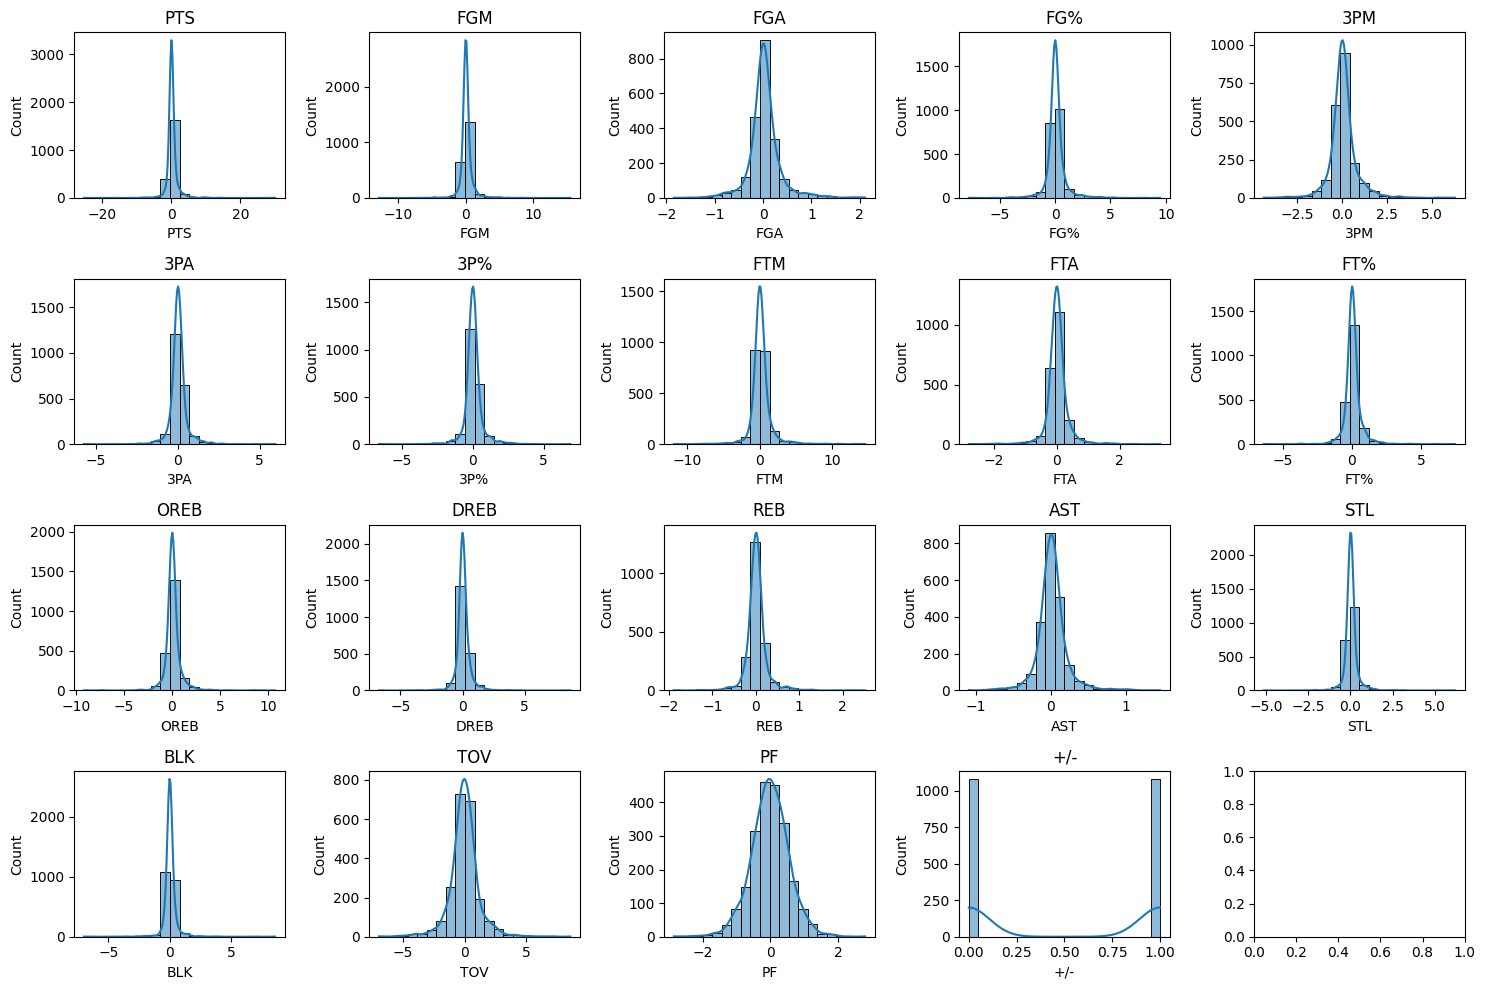

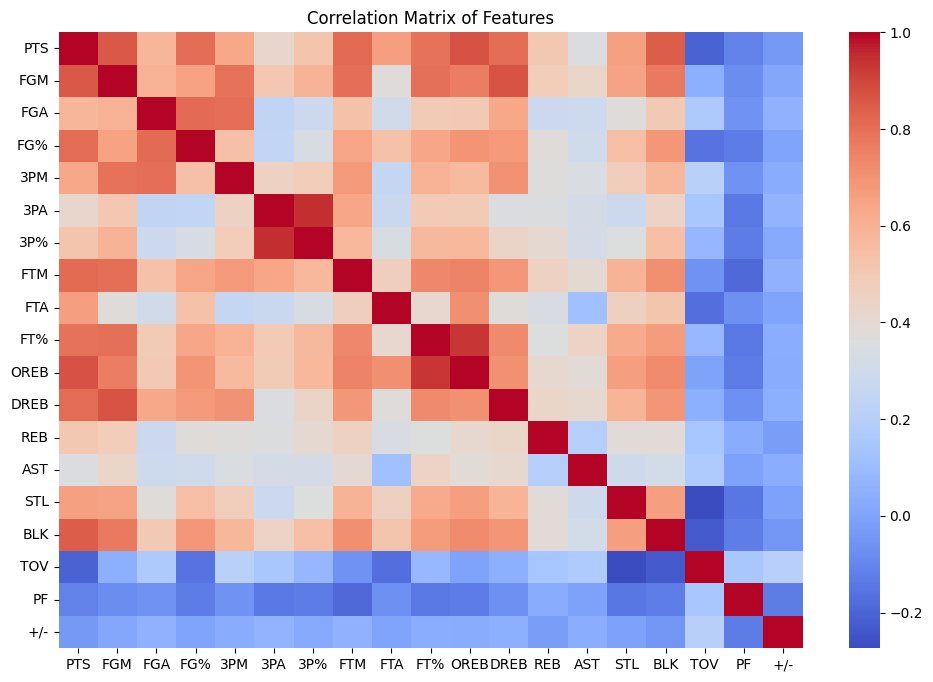

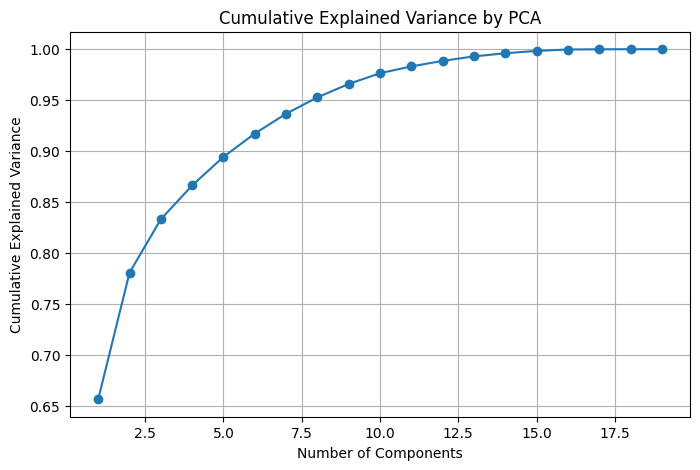


Class balance in the target variable:
1.0    1082
0.0    1078
Name: count, dtype: int64


<ipython-input-39-a290730f1d17>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel")


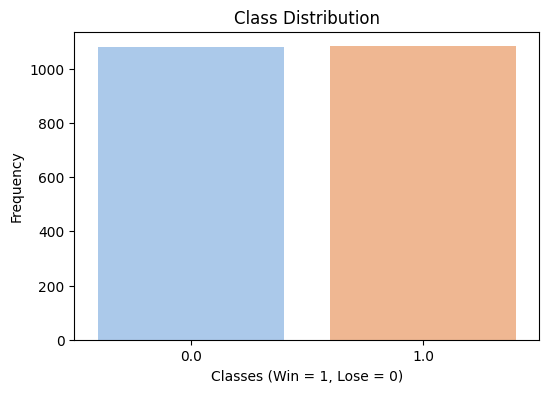

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Check for missing values in the processed dataset
print("Missing values in the dataset:")
print(pd.DataFrame(X_all).isnull().sum())

# Convert the feature-engineered data to a DataFrame for validation
#features_df = pd.DataFrame(X_all, columns=[f"Feature_{i+1}" for i in range(len(X_all[0]))])
features_df = pd.DataFrame(X_all, columns=['PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA',
            'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-'])

# Analyze the distribution of each feature
print("\nFeature distributions:")
features_df.describe()


# Visualize distributions using histograms
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
axes = axes.flatten()
for i, column in enumerate(features_df.columns):
    sns.histplot(features_df[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(column)
plt.tight_layout()
plt.show()

# Check correlation between features (to detect multicollinearity)
correlation_matrix = features_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix of Features")
plt.show()

# PCA for feature redundancy detection
pca = PCA()
pca.fit(features_df)
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title("Cumulative Explained Variance by PCA")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Check class balance in the target variable
print("\nClass balance in the target variable:")
class_counts = pd.Series(y).value_counts()
print(class_counts)

# Visualize class balance
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel")
plt.title("Class Distribution")
plt.xlabel("Classes (Win = 1, Lose = 0)")
plt.ylabel("Frequency")
plt.show()

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Tuning hyperparameters for LDA...
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Tuning hyperparameters for SVM...
Best parameters for SVM: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


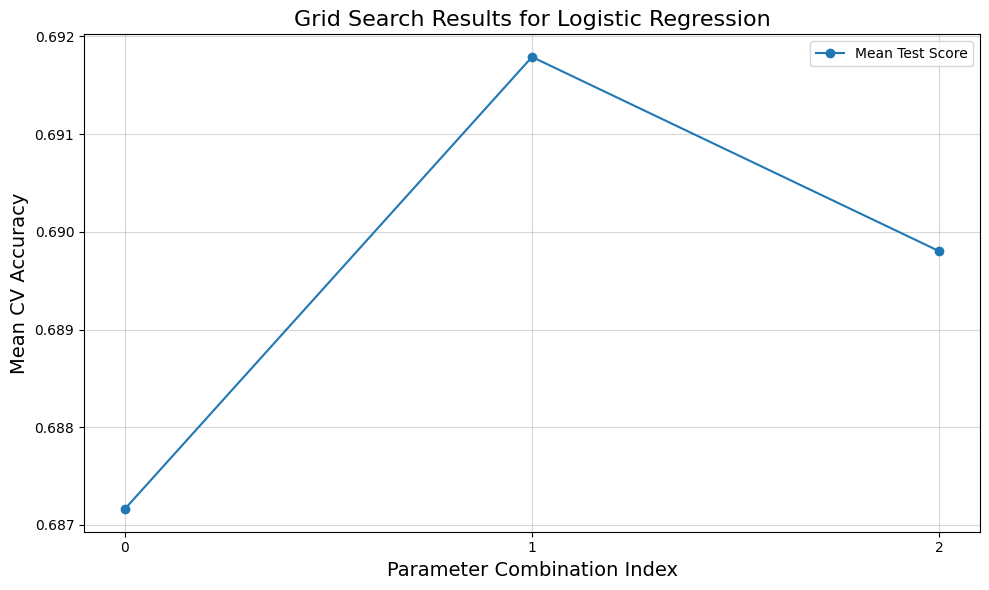

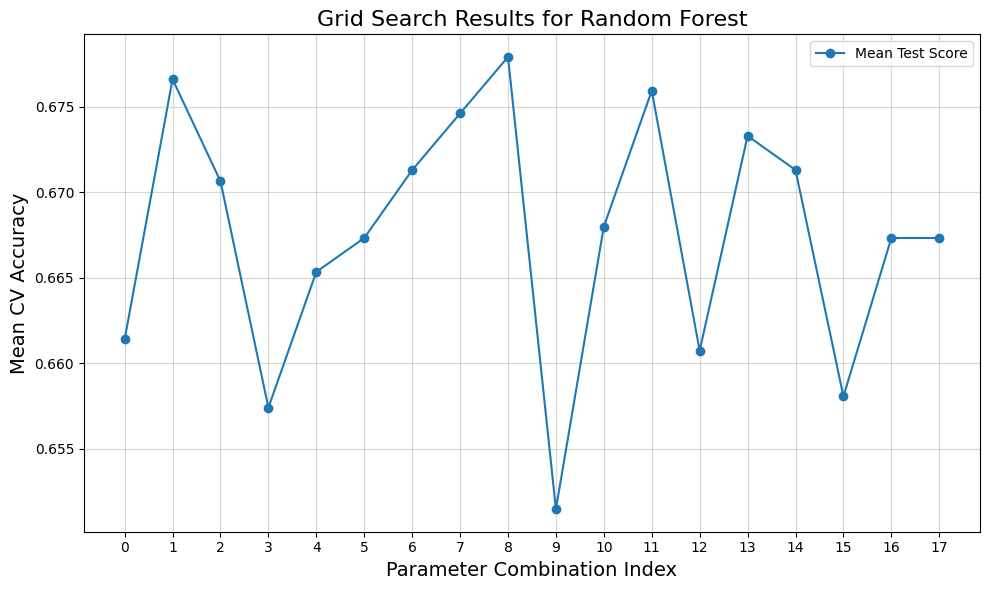

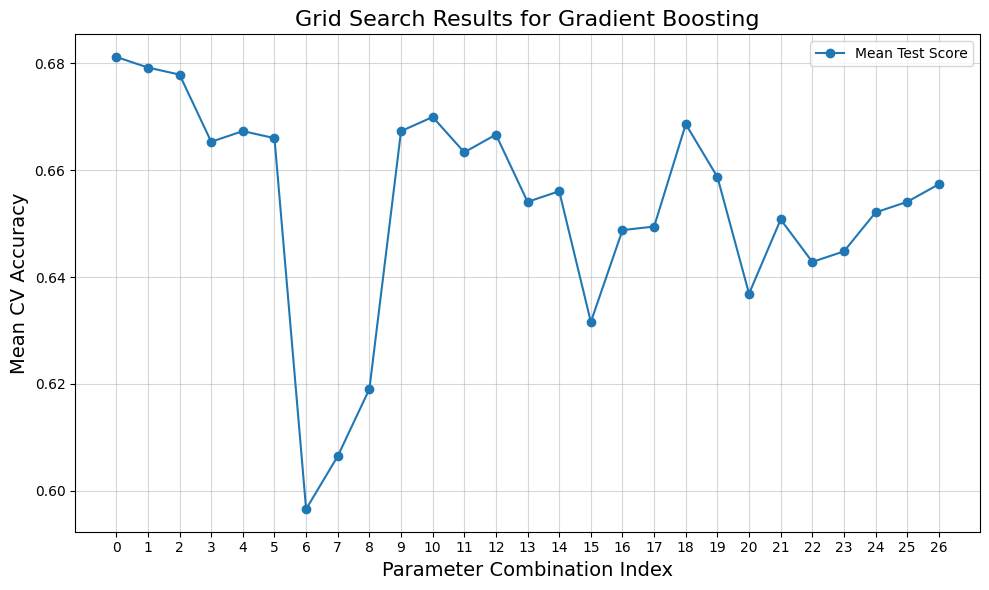

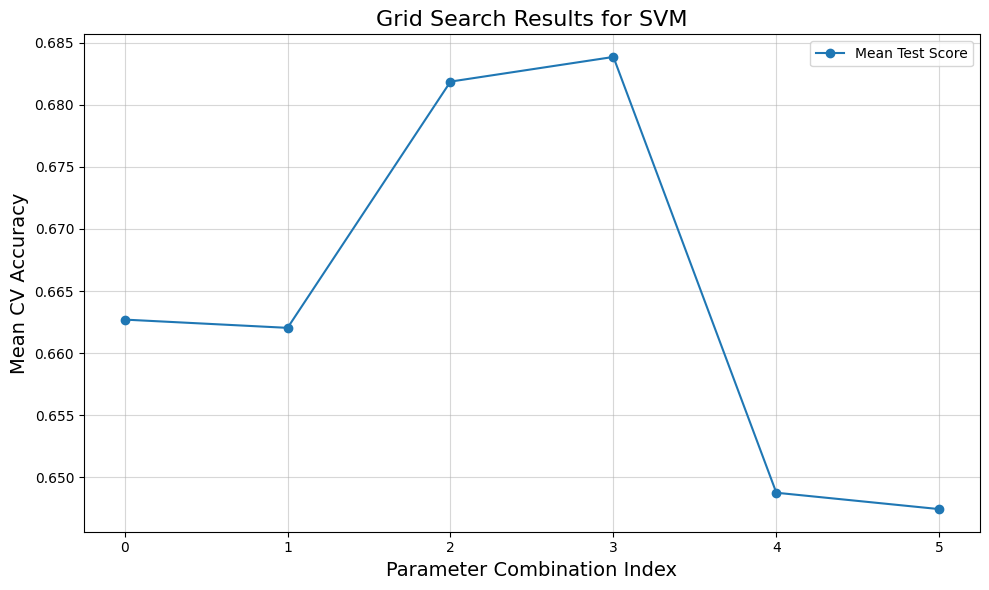

In [ ]:
import matplotlib.pyplot as plt

# Store GridSearchCV results for plotting
grid_search_results = {}

for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}...")
    param_grid = param_grids.get(model_name, {})

    if param_grid:  # Only perform GridSearchCV if hyperparameters are defined
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train, y_train)

        # Save the GridSearchCV results
        grid_search_results[model_name] = grid_search.cv_results_

        best_models[model_name] = grid_search.best_estimator_
        print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[model_name] = model

# Plot GridSearchCV results
for model_name, results in grid_search_results.items():
    # Extract mean test scores and parameter combinations
    mean_test_scores = results["mean_test_score"]
    param_combinations = range(len(mean_test_scores))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(param_combinations, mean_test_scores, marker="o", label="Mean Test Score")
    plt.title(f"Grid Search Results for {model_name}", fontsize=16)
    plt.xlabel("Parameter Combination Index", fontsize=14)
    plt.ylabel("Mean CV Accuracy", fontsize=14)
    plt.xticks(param_combinations)  # Adjust as needed if too many combinations
    plt.grid(alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()